In [1]:
import sys
sys.path.append("../")
import importlib
import train_loops
import run
import torch
from utils import utils
import wandb
import logging
import os 
from pathlib import Path
from configs.config_o2mnist import config

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sample train data


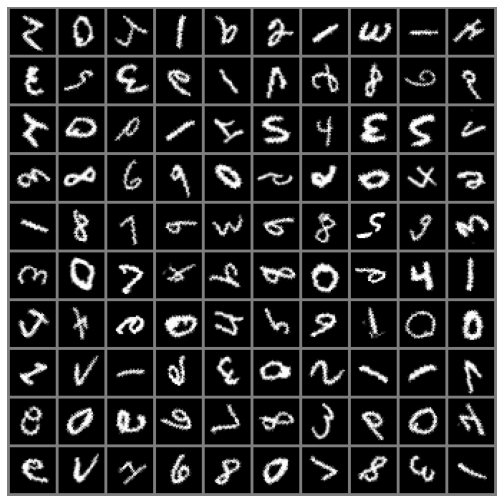

In [2]:
importlib.reload(utils)
# get datasets specified by config.data
dset, loader, dset_test, loader_test = run.get_datasets_from_config(config)
print("sample train data")
f, axs = utils.plot_sample_data(loader)
f

In [3]:
config.model.encoder.n_channels=dset[0][0].shape[0]  # image channels
model = run.build_model_from_config(config)

# optimizer - by default, no lr scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=config.optimizer.lr)

print(model.model_details())

Encoder type <class 'models.encoders_o2.e2scnn.E2SFCNN'>
Decoder type <class 'models.decoders.cnn_decoder.CnnDecoder'>
Bottleneck dims 256
Loss func: bce, beta=0.01 loss aligns output: True 
Parameter counts: 
 encoder 194,464
 decoder 326,401
 total   520,865


## Load pretrained model
**Important** change the below variable `dir_home` to point at 

In [4]:
dir_home = "/pasteur/u/jmhb/o2vae"

In [5]:
f_pretrained_model = os.path.join(dir_home, "wandb/pretrained_models/model_o2_mnist.pt")
print(f"Loading pretrained model {f_pretrained_model}")
model_checkpoint = torch.load(f_pretrained_model)
model.to(device).cpu().train()       # if keys don't match, try many combinations of putting it on and off cuda
model.load_state_dict(model_checkpoint['model_state_dict'])

Loading pretrained model /pasteur/u/jmhb/o2vae/wandb/pretrained_models/model_o2_mnist.pt


<All keys matched successfully>

## Extract features

Left: reconstructions.
Right: reconstructions where output is re-algined


/pasteur/u/jmhb/miniconda3/envs/o2vae/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/pasteur/u/jmhb/miniconda3/envs/o2vae/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


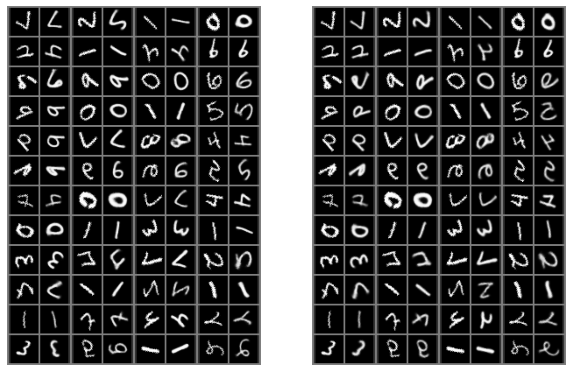

In [6]:
from utils import eval_utils
import matplotlib.pyplot as plt
importlib.reload(eval_utils)
model.eval().cpu() 

x,y = next(iter(loader_test))
reconstruct_grid = eval_utils.reconstruction_grid(model, x, align=False)
reconstruct_grid_aligned = eval_utils.reconstruction_grid(model, x, align=True)
f,axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(reconstruct_grid)
axs[1].imshow(reconstruct_grid_aligned)
print("Left: reconstructions.")
print("Right: reconstructions where output is re-algined")
axs[0].set_axis_off();  axs[1].set_axis_off()

## Extract features

In [7]:
device='cuda'
embeddings, labels = utils.get_model_embeddings_from_loader(model, loader, return_labels=True)
embeddings_test, labels_test = utils.get_model_embeddings_from_loader(model, loader_test, return_labels=True)

100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


## UMAP

In [8]:
import umap
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(embeddings)


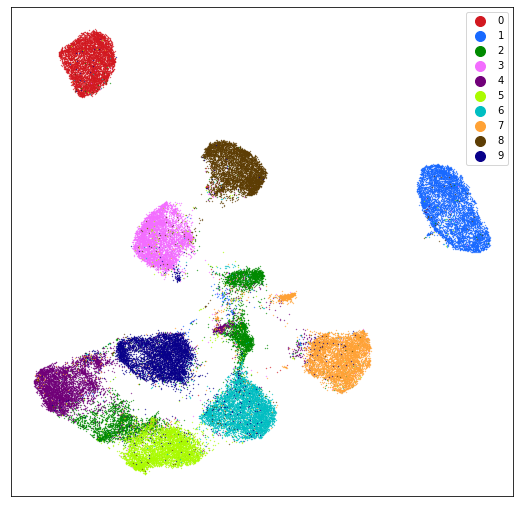

In [9]:
from analysis import plotting_utils

f,axs = plotting_utils.plot_embedding_space_w_labels(umap_embedding, labels)
f

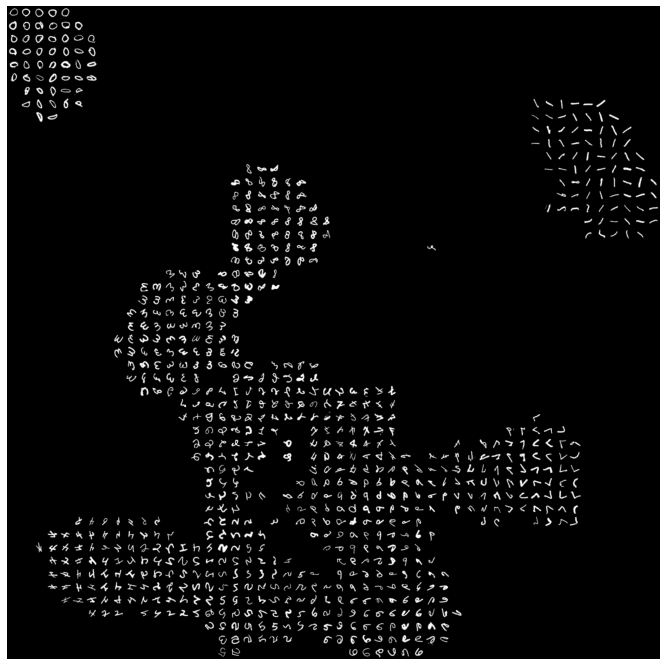

In [22]:
# this requires access to an array of the original images
images = loader.dataset.tensors[0]
images.shape, umap_embedding.shape
grid, idxs = plotting_utils.get_embedding_space_embedded_images(umap_embedding, images, n_ximgs=50, n_yimgs=50)
f, axs = plt.subplots(figsize=(12,12))
axs.set_axis_off()
axs.imshow(grid, cmap='gray')

## Clustering 


In [12]:
## for example, fully unsupervised clustering gets a pretty good clustering score
### some basic clustering
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import sklearn
if 1:
    cls = KMeans(10).fit(umap_embedding)
    labels_pred = cls.labels_
else:
    gmm = GaussianMixture(10).fit(umap_embedding)
    labels_pred = gmm.predict(umap_embedding)

def purity_score(y_true, y_pred):
    """ https://stackoverflow.com/questions/34047540/python-clustering-purity-metric """
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity_score(labels, labels_pred)

0.8945666666666666